In [1]:
import gymnasium as gym
import torch
import torch.optim as optim
import numpy as np
import time
import matplotlib.pyplot as plt

import my_package
from my_package.core.AC_v2 import AC_agent, ReplayBuffer
from my_package import eps_decay as noise_decay

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gamma = 0.99

noise_max = 0.5
noise_min = 0.05
exploration_fraction = 1.0
noise_std = 0.25

hidden_layer_dim = 256
actor_lr = 1e-4
critic_lr = 1e-4
tau = 0.001

buffer_size = 100000
batch_size = 256
max_episodes = 500
data_window = 50

env_name = 'ShipUniCont-v0'
Options = {
    'generate_random_ship':             True,
    'workspace_safe_distance':          2,
    'ship_scale_factor':                0.9,
    'segments_lenght':                  0.25,
    'frame_per_step':                   10,
    'init_pose':                        None,
    'agent_radius':                     0.1,
    'v_surge_max':                      0.05,
    'n_actions':                        1,
    'frontal_safe_distance':            0.5,
    'lidar_params':                     {'n_beams': 10, 'max_range': 2.0, 'FoV': np.pi/2},
    'draw_lidar':                       True,
    'max_steps':                        2000
}	


""" Init buffer """
buffer = ReplayBuffer(capacity=buffer_size)

""" Init env """
env = gym.make(env_name, Options=Options)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

""" Init AC agent """
agent = AC_agent(
    state_dim=state_dim, 
    action_dim=action_dim, 
    hidden_dim=hidden_layer_dim,
    actor_lr=actor_lr,
    critic_lr=critic_lr,
    tau=tau,
    device=device,
    gamma=gamma
)

""" Data collect variables """
total_rewards = np.zeros(max_episodes)
noise_history = np.zeros(max_episodes)
len_episodes = np.zeros(max_episodes)
critic_loss_history = []
actor_loss_history = []
coverage_per_ep = np.zeros(max_episodes)

In [3]:
start_time = time.time()

for episode in range(max_episodes):
    state, info = env.reset()
    state =  2 * state - 1 
    done = False
    noise_std = noise_decay(episode, max_episodes, noise_min, noise_max, exploration_fraction, 'linear')
    noise_history[episode] = noise_std
    
    while not done:
        action = agent.select_action(state, noise_std=noise_std)
        next_state, reward, terminated, truncated, info = env.step(action)
        next_state = 2 * next_state - 1
        buffer.push(state, action, reward, next_state, terminated)
        done = terminated or truncated

        # Ottimizzo policy net e soft update target net
        if len(buffer) > batch_size:
            agent.update(buffer, batch_size, debug=False)
            # critic_loss, actor_loss = agent.update(buffer, batch_size, debug=False)
            # critic_loss_history.append(critic_loss)
            # actor_loss_history.append(actor_loss)

        total_rewards[episode] += reward
        len_episodes[episode] += 1
        state = next_state

    coverage_per_ep[episode] = info['coverage']
    
    if episode % data_window == 0 and episode != 0:
        ma_reward = np.mean(total_rewards[episode-data_window:episode])
        ma_coverage = np.mean(coverage_per_ep[episode-data_window:episode])
        print(f"Ep {episode}/{max_episodes}, MA Reward: {ma_reward:.2f}, MA Coverage: {ma_coverage:.1f} % , Noise: {noise_std:.2f}")

env.close()

total_time_seconds = time.time() - start_time
hours = int(total_time_seconds // 3600)
minutes = int((total_time_seconds % 3600) // 60)
seconds = int(total_time_seconds % 60)
print(f"Training finito in: {hours} ore {minutes} minuti e {seconds} secondi")

C:\Users\paolo\miniconda3\envs\gymenv\Lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


Ep 50/500, MA Reward: -41.85, MA Coverage: 1.1 % , Noise: 0.45
Ep 100/500, MA Reward: -40.48, MA Coverage: 0.1 % , Noise: 0.40
Ep 150/500, MA Reward: -38.98, MA Coverage: 19.6 % , Noise: 0.35
Ep 200/500, MA Reward: -6.96, MA Coverage: 58.9 % , Noise: 0.30
Ep 250/500, MA Reward: 8.74, MA Coverage: 76.7 % , Noise: 0.25
Ep 300/500, MA Reward: -0.12, MA Coverage: 75.9 % , Noise: 0.20
Ep 350/500, MA Reward: 8.65, MA Coverage: 83.2 % , Noise: 0.15
Ep 400/500, MA Reward: 16.34, MA Coverage: 88.9 % , Noise: 0.10
Ep 450/500, MA Reward: 26.26, MA Coverage: 96.8 % , Noise: 0.05
Training finito in: 1 ore 55 minuti e 12 secondi


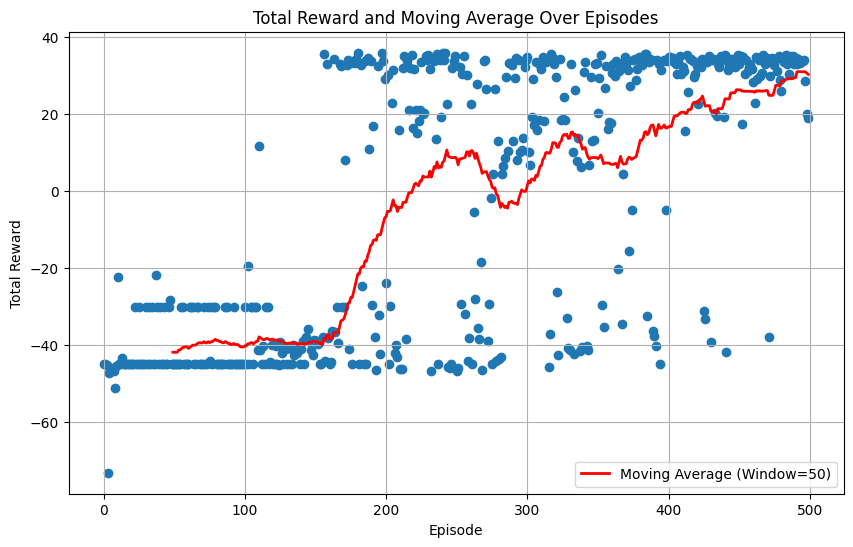

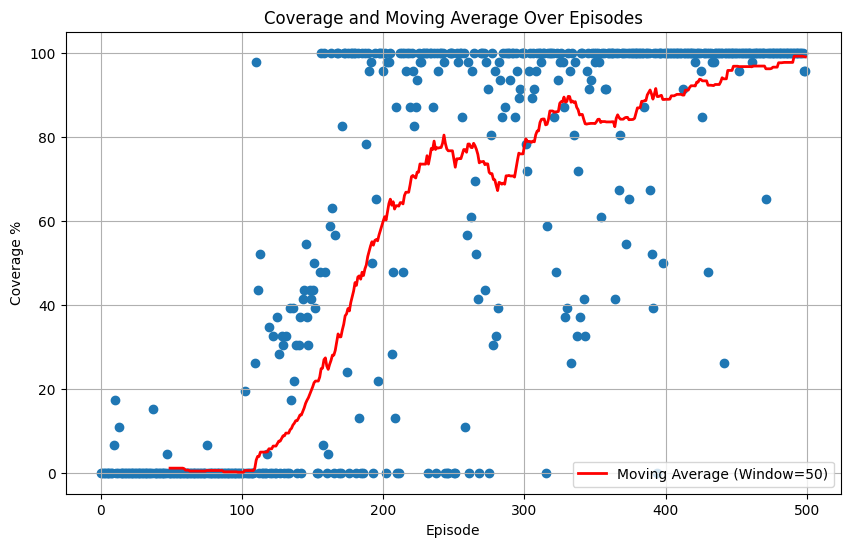

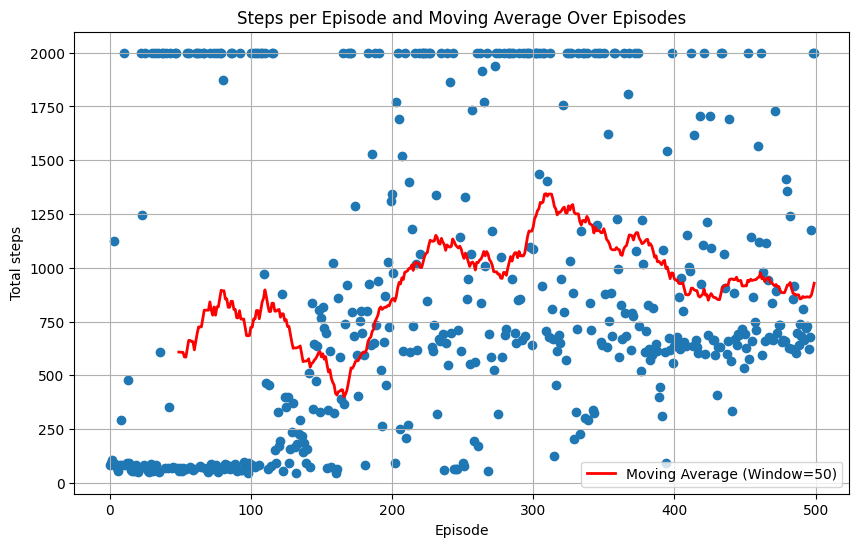

In [4]:
""" Plot rewards """
window_size = 50
ma_reward = np.convolve(total_rewards, np.ones(window_size) / window_size, mode='valid')
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(total_rewards)), total_rewards)
plt.plot(np.arange(window_size - 1, len(total_rewards)), ma_reward, color='red', label=f'Moving Average (Window={window_size})', linewidth=2)
plt.title('Total Reward and Moving Average Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)
plt.show()


""" Plot coverage """
window_size = 50
ma_coverage = np.convolve(coverage_per_ep, np.ones(window_size) / window_size, mode='valid')
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(coverage_per_ep)), coverage_per_ep)
plt.plot(np.arange(window_size - 1, len(coverage_per_ep)), ma_coverage, color='red', label=f'Moving Average (Window={window_size})', linewidth=2)
plt.title('Coverage and Moving Average Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Coverage %')
plt.legend()
plt.grid(True)
plt.show()

""" Plot episode duration """
window_size = 50
ma_steps = np.convolve(len_episodes, np.ones(window_size) / window_size, mode='valid')
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(len_episodes)), len_episodes)
plt.plot(np.arange(window_size - 1, max_episodes), ma_steps, color='red', label=f'Moving Average (Window={window_size})', linewidth=2)
plt.title('Steps per Episode and Moving Average Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Total steps')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
env = gym.make(env_name, Options=Options, render_mode='human')

for ep in range(1):
    state, info = env.reset()
    STATE = 2 * state - 1
    done = False
    total_reward = 0
    steps = 0
    while not done:
        action = agent.select_action(state, 0.0)
        next_state, reward, terminated, truncated, info = env.step(action)
        next_state = 2 * next_state - 1
        done = terminated or truncated
        state = next_state
        total_reward += reward
    if info['collision']:
        ending_cause = "collision"
    elif info['out_of_bounds']:
        ending_cause = "out of bounds"
    elif info['time_limit']:
        ending_cause = "max steps reached"
    elif info['coverage'] == 100:
        ending_cause = "100% coverage"
    else:
        ending_cause = "unkown"
    print('total reward: ' + str(total_reward) + ' end episode for: ' + ending_cause)
env.close()

total reward: 33.43000000000003 end episode for: 100% coverage


In [11]:
noise_min = noise_max
checkpoint = {
    'gamma' : gamma,
    'noise_max' : noise_max,
    'noise_min' : noise_min,
    'exploration_fraction' : exploration_fraction,
    'state_dim': state_dim,
    'action_dim': action_dim,
    'hidden_layer_dim' : hidden_layer_dim,
    'actor_lr': actor_lr,
    'critic_lr': critic_lr,
    'tau' : tau,
    'buffer_size' : buffer_size,
    'batch_size' : batch_size,
    'max_episodes' : max_episodes,
    'actor_state_dict': agent.actor.state_dict(),
    'critic_state_dict': agent.critic.state_dict(),
    'total_rewards': total_rewards,
    'len_episodes' : len_episodes,
    'coverage_per_ep': coverage_per_ep,
    'Options' : Options,
    'env_name': env_name,
    'AC_version': 'AV_v2',
    'noise_history': noise_history
}

path = "ShipUniCont_v0/" + env_name + "_" + str(max_episodes) + "_ep_" + str(action_dim) + "_actions_AC_v2.0_and_norm_state.pth"
torch.save(checkpoint, path)